scanpy version: 1.3.3


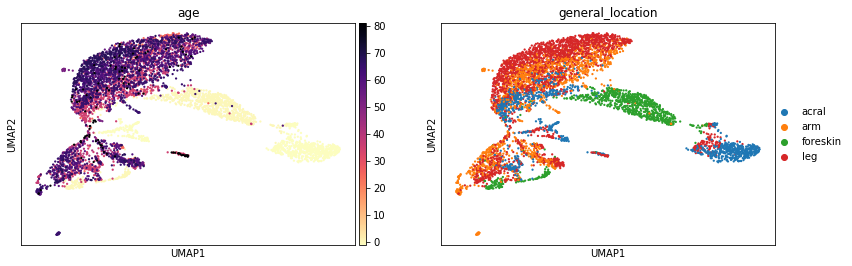

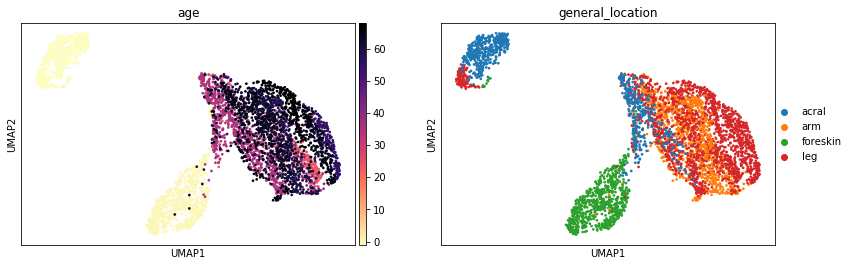

In [47]:
###############################################
###############################################
# Setup
# This chuck ingests pre-computed variables
###############################################
###############################################

# [Shift + Return] to run chunks 

###############################################

# settings
wkdir, s3dir = '/home/ubuntu/data/DL20181011_melanocyte_test_data', 'daniel.le-work/MEL_project'

%reload_ext autoreload
%autoreload 2
from scanpy_helpers import *
print ('scanpy version: {}'.format(sc.__version__))
warnings.filterwarnings('ignore')
%matplotlib inline

# import data from s3
for file in ['adata_subset1', 'adata_subset2', 'full_adata', 'pre_adata','adata_subset1_KRT']:
#     ! aws s3 cp s3://{s3dir}/{file}.p {wkdir}/
    var = pickle.load((open(f'{wkdir}/{file}.p', 'rb')))
    exec(f'{file} = var')
    del var

# drop patients due to low cell count
adata_subset2_filtered = adata_subset2[[x not in ['A1015LM',
                                                'A1017LM',
                                                'A1012M'] for x in adata_subset2.obs.patient.tolist()]] 

# plot full data
sc.pl.umap(full_adata, color=['age','general_location'], cmap = 'magma_r')
sc.pl.umap(adata_subset2_filtered, color=['age','general_location'], cmap = 'magma_r')


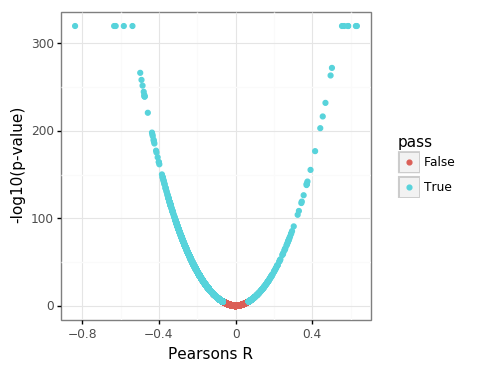

<ggplot: (-9223363299738970834)>
           gene         R           pval        R2  neglog10_pval
8121   SERPINF1 -0.837793  1.475774e-320  0.701898     319.830980
1297      CCND1 -0.634014  1.475774e-320  0.401973     319.830980
1768     CRABP1  0.632616  1.475774e-320  0.400203     319.830980
1624        CLU  0.627338  1.475774e-320  0.393553     319.830980
3760     IGFBP3 -0.625875  1.475774e-320  0.391719     319.830980
3550      HLA-B  0.586798  1.475774e-320  0.344332     319.830980
3551      HLA-C  0.586586  1.475774e-320  0.344083     319.830980
6118        MYC -0.583468  1.475774e-320  0.340435     319.830980
7929     S100A6  0.566239  1.475774e-320  0.320626     319.830980
450        APOD  0.554880  1.475774e-320  0.307892     319.830980
7489       QPRT -0.538378  1.475774e-320  0.289851     319.830980
677         B2M  0.502370  1.009238e-272  0.252376     271.996006
3678      HSPD1 -0.497827  4.377808e-267  0.247832     266.358743
6246      NDRG2  0.495353  4.727177e-264  0

This gene encodes a key enzyme in catabolism of quinolinate, an intermediate in the tryptophan-nicotinamide adenine dinucleotide pathway. Quinolinate acts as a most potent endogenous exitotoxin to neurons. Elevation of quinolinate levels in the brain has been linked to the pathogenesis of neurodegenerative disorders such as epilepsy, Alzheimer's disease, and Huntington's disease. Alternative splicing results in multiple transcript variants. [provided by RefSeq, Dec 2015].
11: B2M
This gene encodes a serum protein found in association with the major histocompatibility complex (MHC) class I heavy chain on the surface of nearly all nucleated cells. The protein has a predominantly beta-pleated sheet structure that can form amyloid fibrils in some pathological conditions. The encoded antimicrobial protein displays antibacterial activity in amniotic fluid. A mutation in this gene has been shown to result in hypercatabolic hypoproteinemia.[provided by RefSeq, Aug 2014].
12: HSPD1
This gene en

In [77]:
###############################################
###############################################
# Correlation between expression and true age
# Returns correlation statistics and gene function annotation
###############################################
###############################################

# Specify number of genes to print from top of list sorted on R2
topn = 20

# Specify whether to use all samples or only adult samples in correlation
adults_only = False

###############################################

ref = 'age'
input_adata = adata_subset2
if adults_only == True:
    input_adata = input_adata[input_adata.obs.age > 0]
corr_age = pd.DataFrame(input_adata.X)
corr_age.columns = input_adata.var_names
corr_age[ref] = input_adata.obs[ref].tolist()

df = corr_age.dropna()._get_numeric_data()
r_list = []
p_list = []
gene_list = []
for col in df.columns.tolist():
    r, pval = pearsonr(df[ref], df[col])
    r_list.append(r)
    p_list.append(pval)
    gene_list.append(col)
out_df = pd.DataFrame({'gene':gene_list,
                       'R':r_list, 
                       'pval':p_list})
out_df = out_df.iloc[[x != ref for x in out_df['gene']],:]
out_df['R2'] = out_df['R']**2 
out_df = out_df.sort_values('R2', ascending=False)
out_df['pval'] = out_df['pval'].replace(0, min([x for x in out_df['pval'] if x>0]))
out_df['neglog10_pval'] = -np.log10(out_df['pval'])
out_df['pass'] = out_df.neglog10_pval > -np.log10(0.05/len(df))

# plot R vs p-value
plotnine.options.figure_size=(4,4)
print(ggplot(out_df)
          +theme_bw()
          +geom_point(aes('R','neglog10_pval', color = 'pass'))
          +labs(x='Pearsons R', y='-log10(p-value)'))

# print correlation scores table
print(out_df.drop('pass', axis = 1).head(topn))

# search correlation df
gene = out_df.gene[:topn]
out = symbol2field(gene)
full_report = ['{}: {}\n{}'.format(idx,
                            x['query'],
                            x['summary']) if ('summary' in x.keys()) else '{}: {}\n{}'.format(idx,
                            x['query'],
                            'N/A') for idx, x in enumerate(out)]
search_term = ''
output = [print(x) for x in full_report if search_term in x]

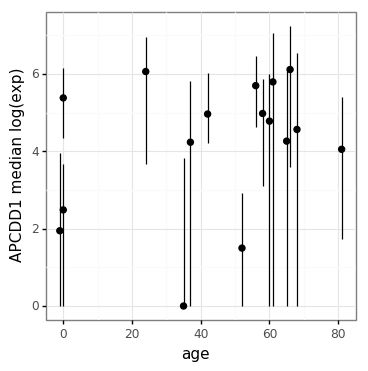

<ggplot: (8737107233663)>


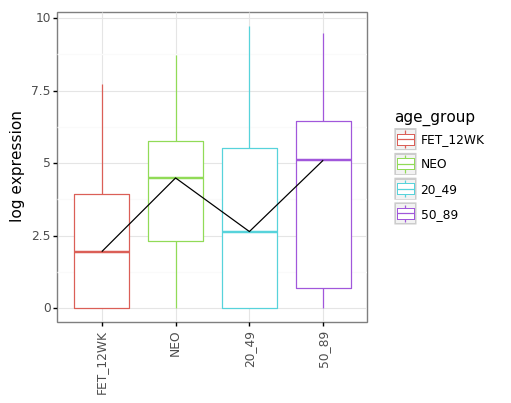

<ggplot: (8737106857736)>


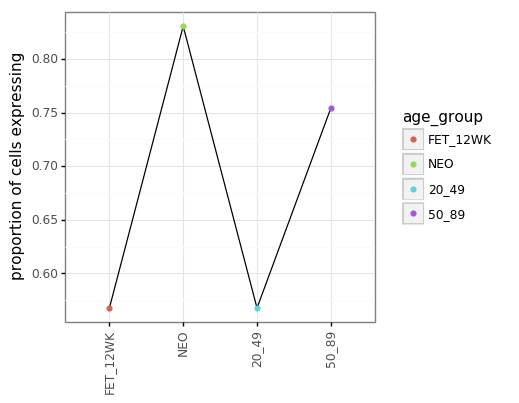

<ggplot: (8737106857918)>


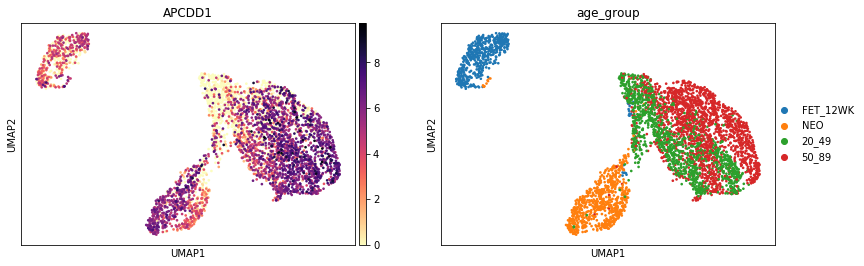

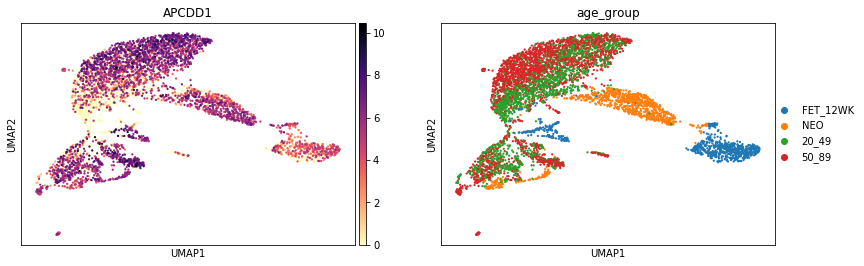

querying 1-1...done.
Finished.
0:  APCDD1 
 This locus encodes an inhibitor of the Wnt signaling pathway. Mutations at this locus have been associated with hereditary hypotrichosis simplex. Increased expression of this gene may also be associated with colorectal carcinogenesis.[provided by RefSeq, Sep 2010].


In [78]:
###############################################
###############################################
# Single-gene expression statistics
# Returns single-gene expression statistics as a function of true age
###############################################
###############################################

# Specify gene symbol
gene = 'APCDD1'

# Specify age-binning: 'age_group' = 30-yr bins, 'age_bin' = 10-yr bins
groupby='age_group'

###############################################

# true age
true_age_exp(gene, input_adata)

# binned age
gene2plots(input_adata, gene, groupby)
sc.pl.umap(input_adata, color=[gene, groupby], cmap='magma_r')
sc.pl.umap(full_adata, color=[gene, groupby], cmap='magma_r')

out = symbol2field(gene)
output = [print(f'{idx}: ', 
       x['query'],
       '\n',x['summary']) if ('summary' in x.keys()) else print(f'{idx}: ', 
                                                                x['query'],
                                                                '\n','N/A') for idx, x in enumerate(out)]


# Dev

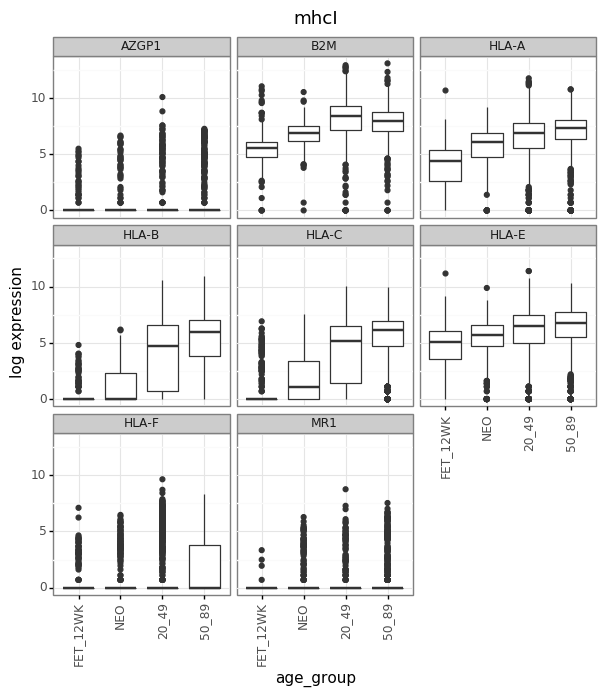

<ggplot: (-9223363299747755120)>


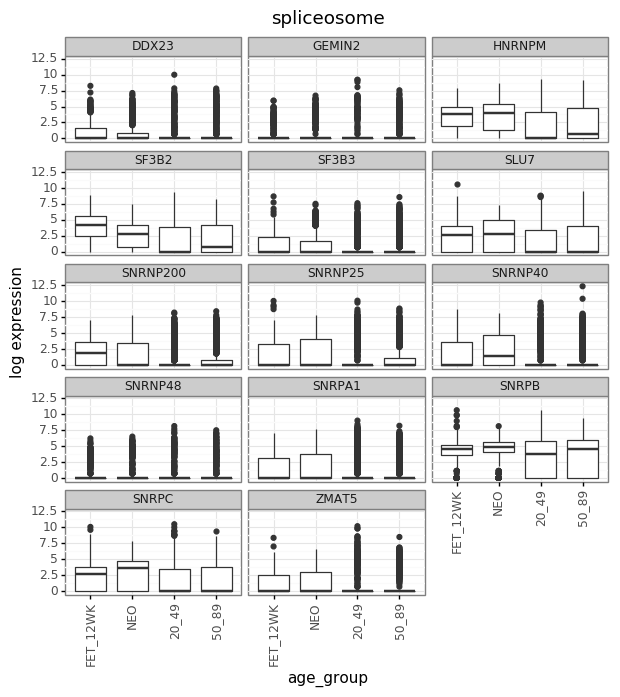

<ggplot: (-9223363299736926716)>


In [79]:
input_adata = adata_subset2
groupby='age_group'
set_names = ['mhcI','spliceosome']

for set_name in set_names:
    geneset = pd.read_csv(f's3://daniel.le-work/MEL_project/{set_name}_genes.txt',
               delimiter = '\t', usecols=[1], header=None)
    geneset.columns = ['gene']
    geneset = [x for x in geneset.gene if x in input_adata.var_names]
    cats, casted_df = prepare_dataframe(input_adata, 
                                             geneset, 
                                             groupby=groupby)

    melt_df = pd.melt(casted_df.reset_index(), id_vars=groupby)
  
    plotnine.options.figure_size = (7,7)
    print(ggplot(melt_df)
         +theme_bw()
         +theme(axis_text_x=element_text(angle=90),
               legend_position = 'none')
         +geom_boxplot(aes(groupby, 'value'))
         +labs(x=groupby,y='log expression')
         +ggtitle(set_name)
         +facet_wrap('~variable', ncol=3))
    

# compare expression of MHC in krts

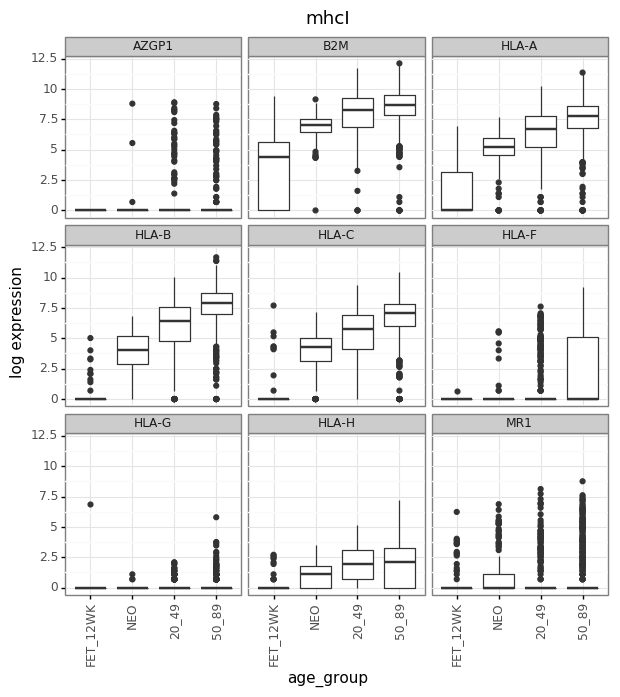

<ggplot: (-9223363299774911954)>


In [56]:
input_adata = adata_subset1_KRT
groupby='age_group'
set_names = ['mhcI']

for set_name in set_names:
    geneset = pd.read_csv(f's3://daniel.le-work/MEL_project/{set_name}_genes.txt',
               delimiter = '\t', usecols=[1], header=None)
    geneset.columns = ['gene']
    geneset = [x for x in geneset.gene if x in input_adata.var_names]
    cats, casted_df = prepare_dataframe(input_adata, 
                                             geneset, 
                                             groupby=groupby)

    melt_df = pd.melt(casted_df.reset_index(), id_vars=groupby)
  
    plotnine.options.figure_size = (7,7)
    print(ggplot(melt_df)
         +theme_bw()
         +theme(axis_text_x=element_text(angle=90),
               legend_position = 'none')
         +geom_boxplot(aes(groupby, 'value'))
         +labs(x=groupby,y='log expression')
         +ggtitle(set_name)
         +facet_wrap('~variable', ncol=3))
    